# Import Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yfinance as yf
import pandas_datareader.data as web
from datetime import date, timedelta
import datetime

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Collection

In [8]:
# GDP
start_date = datetime.datetime(1947, 1, 1)
end_date = datetime.datetime.now()
gdp = web.DataReader("GDP","fred",start_date,end_date)
# gdp['Recession'] = 0
gdp['GDP_change'] = gdp['GDP'].diff()
gdp = gdp.drop('GDP', axis=1)
# gdp.loc[(gdp['GDP_change'] < 0), 'Recession'] = 1
gdp

,GDP_change
DATE,
1947-01-01,NaN
1947-04-01,2.804
1947-07-01,3.617
1947-10-01,10.160
1948-01-01,5.997
...,...
2022-01-01,391.359
2022-04-01,507.996
2022-07-01,475.465


In [9]:
# Unemployment
start = datetime.datetime(1947, 1, 1)
end = datetime.datetime.now()
unemployment = web.DataReader('UNRATE', 'fred', start, end)
unemployment['UNRATE_change'] = unemployment['UNRATE'].diff()
unemployment = unemployment.drop('UNRATE', axis=1)
unemployment

,UNRATE_change
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4
...,...
2022-11-01,-0.1
2022-12-01,-0.1
2023-01-01,-0.1


In [10]:
# Stock market
stock = yf.download('^GSPC', '1947-1-1', '2023-4-30')
# end date of '2023-4-30' was used for research

[*********************100%***********************]  1 of 1 completed


In [11]:
# Combine datasets
data = pd.concat([gdp, stock, unemployment], axis=1)
data['GDP_change'] = data['GDP_change'].fillna(method = 'ffill')
data['UNRATE_change'] = data['UNRATE_change'].fillna(method = 'ffill')
data = data[['GDP_change', 'UNRATE_change', 'Adj Close']]
data['GDP'] = np.log(data['GDP_change'])
data['Adj Close'] = np.log(data['Adj Close'])
data = data[18000:]

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Preprocessing

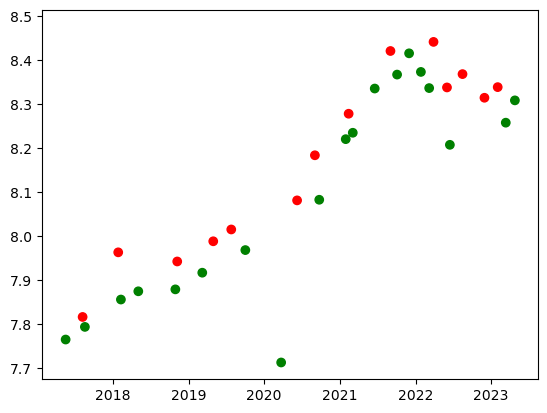

In [12]:
# Visualization of target variable (local minima and maxima)
local_max_indices = argrelextrema(data['Adj Close'].values, np.greater, order=15)[0]
local_min_indices = argrelextrema(data['Adj Close'].values, np.less, order=15)[0]
data['local_min_max'] = 0
data.loc[data.index.isin(data.index[local_max_indices]), 'local_min_max'] = -1
data.loc[data.index.isin(data.index[local_min_indices]), 'local_min_max'] = 1
colors = {-1:'r', 1: 'g', 0: '#00000000'}
plt.scatter(data.index, data['Adj Close'], c=data['local_min_max'].map(colors))
plt.show()

In [13]:
# All data
data = pd.concat([gdp, stock, unemployment], axis=1)
data['GDP_change'] = data['GDP_change'].fillna(method = 'ffill')
data['UNRATE_change'] = data['UNRATE_change'].fillna(method = 'ffill')

# Target 
local_max_indices = argrelextrema(data['Adj Close'].values, np.greater, order=1)[0]
local_min_indices = argrelextrema(data['Adj Close'].values, np.less, order=1)[0]
data['local_min_max'] = 0
data.loc[data.index.isin(data.index[local_max_indices]), 'local_min_max'] = -1
data.loc[data.index.isin(data.index[local_min_indices]), 'local_min_max'] = 1

# Features 


# Break autocorrelation
data['local_min_max_lag_1'] = data['local_min_max'].shift(1)
data['local_min_max_lag_2'] = data['local_min_max'].shift(2)

# data['SO'] = self.calc_stochastic_oscillator()
# data['DMI'] = self.calc_directional_movement_indicator()
# data['OBV'] = self.calc_obv()
data['deriv'] = data['Adj Close'].diff()
data['close_open'] = data['Open'] - data['Adj Close'].shift(1)
data['open_close'] = data['Adj Close'] - data['Open']
data['deriv_open'] = data['Open'].diff()
data['2nd_deriv'] = data['Adj Close'].diff().diff()
data['close_pos'] = data['Adj Close'] - (data['High'] + data['Low'])/2 
data['hi_deriv'] = data['High'].diff()
data['low_deriv'] = data['Low'].diff()
# data['5d_SMA'] = data.Close.rolling(window=5).mean()
# data['10d_SMA'] = data.Close.rolling(window=10).mean()
# data['25d_SMA'] = data.Close.rolling(window=25).mean()
# data['50d_SMA'] = data.Close.rolling(window=50).mean()
# data['100d_SMA'] = data.Close.rolling(window=100).mean()
# data['RSI'] = self.calculate_RSI()
data['12d_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
data['26d_EMA'] = data.Close.ewm(span=26, adjust=False).mean()
data['macd'] = data['12d_EMA']- data['26d_EMA'] 
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()



data = data.dropna()
data

,GDP_change,Open,High,Low,Close,Adj Close,Volume,UNRATE_change,local_min_max,local_min_max_lag_1,...,open_close,deriv_open,2nd_deriv,close_pos,hi_deriv,low_deriv,12d_EMA,26d_EMA,macd,macdsignal
1948-02-04,5.997,14.000000,14.000000,14.000000,14.000000,14.000000,0.000000e+00,0.4,1,0.0,...,0.000000,-0.620000,-0.530000,0.000000,-0.620000,-0.620000,14.538842,14.713345,-0.174503,-0.153913
1948-02-05,5.997,14.200000,14.200000,14.200000,14.200000,14.200000,0.000000e+00,0.4,-1,1.0,...,0.000000,0.200000,0.820000,0.000000,0.200000,0.200000,14.486713,14.675319,-0.188607,-0.160852
1948-02-06,5.997,14.190000,14.190000,14.190000,14.190000,14.190000,0.000000e+00,0.4,1,-1.0,...,0.000000,-0.010000,-0.210000,0.000000,-0.010000,-0.010000,14.441065,14.639370,-0.198305,-0.168342
1948-02-09,5.997,14.310000,14.310000,14.310000,14.310000,14.310000,0.000000e+00,0.4,-1,1.0,...,0.000000,0.120001,0.130001,0.000000,0.120001,0.120001,14.420901,14.614972,-0.194071,-0.173488
1948-02-10,5.997,13.890000,13.890000,13.890000,13.890000,13.890000,0.000000e+00,0.4,0,-1.0,...,0.000000,-0.420000,-0.540001,0.000000,-0.420000,-0.420000,14.339224,14.561270,-0.222047,-0.183200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,327.873,4132.069824,4142.410156,4117.770020,4137.040039,4137.040039,3.290940e+09,-0.1,-1,0.0,...,4.970215,-0.070312,-0.209961,6.949951,4.390137,3.910156,4123.020306,4085.664275,37.356031,36.937361
2023-04-25,327.873,4126.430176,4126.430176,4071.379883,4071.629883,4071.629883,3.978640e+09,-0.1,0,-1.0,...,-54.800293,-5.639648,-68.930176,-27.275146,-15.979980,-46.390137,4115.114087,4084.624690,30.489396,35.647768
2023-04-26,327.873,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3.837030e+09,-0.1,1,0.0,...,-31.790039,-38.650146,49.770264,-13.520020,-36.760254,-22.029785,4106.018072,4082.503601,23.514470,33.221108
2023-04-27,327.873,4075.290039,4138.240234,4075.290039,4135.350098,4135.350098,3.750550e+09,-0.1,0,1.0,...,60.060059,-12.489990,95.000000,28.584961,48.570312,25.939941,4110.530691,4086.418157,24.112534,31.399393


In [14]:
# Train test split
features = data.drop('local_min_max', axis=1).columns.to_list()
split = round(len(data)*0.2)
train = data.iloc[:-split]
test = data.iloc[-split:]
X_train = train[features]
y_train = train['local_min_max']
X_test = test[features]
y_test = test['local_min_max']

# Scale features 
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

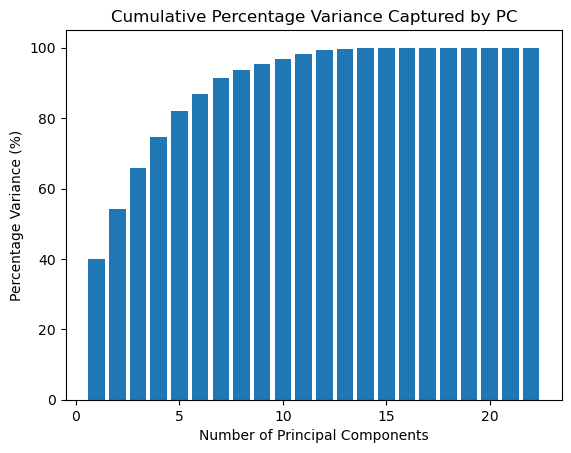

PCs kept for 100% variance: 15


In [24]:
# PCA
pca = PCA(n_components = np.shape(X_train_scaled)[1], svd_solver='full')
pca.fit(X_train_scaled)

plt.bar(range(1, np.shape(X_train_scaled)[1]+1), pca.explained_variance_ratio_.cumsum()*100)
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage Variance (%)')
plt.title('Cumulative Percentage Variance Captured by PC')
plt.show()

pca = PCA(n_components=0.99999, svd_solver = 'full')
pca.fit(X_train_scaled)
print('PCs kept for 100% variance:', len(pca.components_))

pca_15 = PCA(n_components=15, svd_solver = 'full')
pca_15.fit(X_train_scaled)
X_train_scaled = pca_15.transform(X_train_scaled)
X_test_scaled = pca_15.transform(X_test_scaled)

# Supervised Learning (Prediction)

**Logistic Regression**


**OUTPUT SUGGESTS UNDERFITTING: C too low (too much regularization), test accuracy significantly lower, and all features except 1 got penalized completely --> increase model complexity**

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters:  {'C': 0.001, 'penalty': 'l1'}
Best accuracy score:  0.5578644980750245
Test accuracy 0.5028712059064807


{'deriv': 0.1663103274570581,
 'GDP_change': 0.0,
 'Open': 0.0,
 'High': 0.0,
 'Low': 0.0,
 'Close': 0.0,
 'Adj Close': 0.0,
 'Volume': 0.0,
 'UNRATE_change': 0.0,
 'close_open': 0.0,
 'open_close': 0.0,
 'deriv_open': 0.0,
 '2nd_deriv': 0.0,
 'close_pos': 0.0,
 'hi_deriv': 0.0,
 'low_deriv': 0.0,
 '12d_EMA': 0.0,
 '26d_EMA': 0.0,
 'macd': 0.0,
 'macdsignal': 0.0}

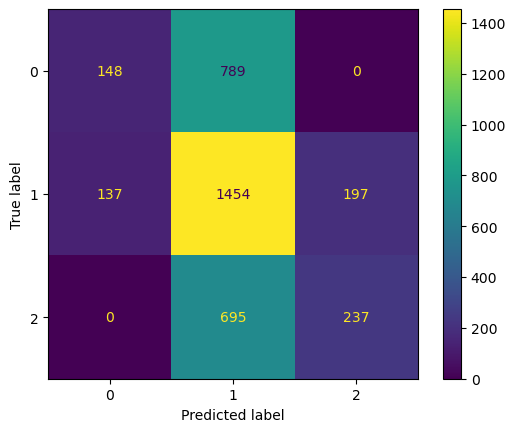

In [10]:
# Hyperparameter tuning
model = LogisticRegression(max_iter = 10000, solver = 'liblinear', random_state = 0)
model.fit(X_train_scaled, y_train)
grid = {'C': [10**i for i in range(-4, 2)], 'penalty': ['l1', 'l2']}
clf = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='accuracy', verbose=1)
clf.fit(X_train_scaled, y_train)

# Test results
print("Best hyperparameters: ", clf.best_params_)
print("Best accuracy score: ", clf.best_score_)

final_model = clf.best_estimator_
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy", accuracy)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
coef_dict = {}
for coef, feat in zip(final_model.coef_[0,:],X_test.columns):
    coef_dict[feat] = coef
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True))
sorted_coef_dict

**KNN (non-parametric, more complex, and computationally inexpensive for grid search)** 

**Similar accuracy, but less overfitting and more buy/sell predictions --> more liquid and reduces volatility**

Fitting 5 folds for each of 98 candidates, totalling 490 fits
Best hyperparameters:  {'n_neighbors': 49, 'weights': 'uniform'}
Best accuracy score:  0.45806193806193807
Test accuracy 0.5042384468143287


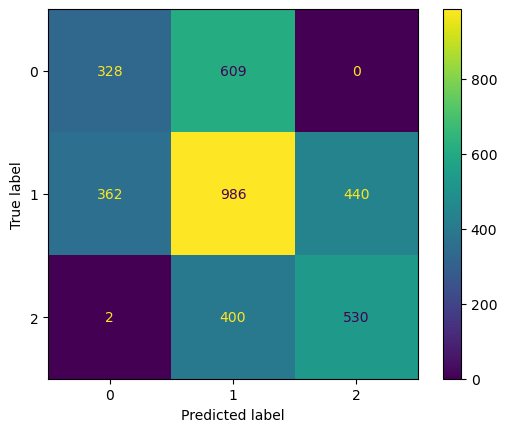

In [25]:
# Hyperparameter tuning
model = KNeighborsClassifier()
grid = {'n_neighbors': list(range(1, 50)), 'weights': ['uniform', 'distance']}
clf = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='accuracy', verbose=1)
clf.fit(X_train_scaled, y_train)

# Test results
print("Best hyperparameters: ", clf.best_params_)
print("Best accuracy score: ", clf.best_score_)

final_model = clf.best_estimator_
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy", accuracy)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Backtesting

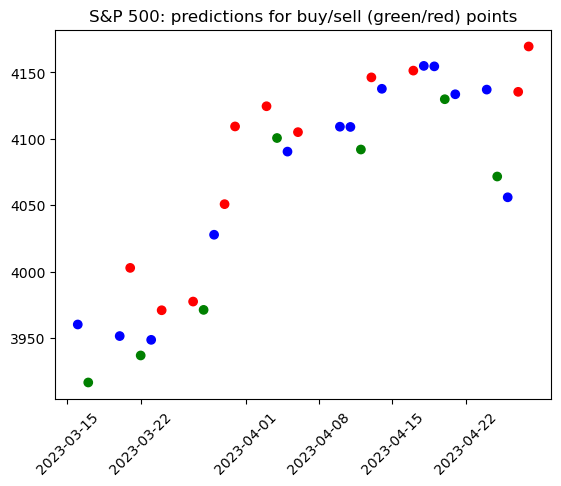

In [34]:
pca_columns = str(range(15))
prob = np.max(final_model.predict_proba(X_test_scaled), axis=1)
y_pred = pd.DataFrame(data = y_pred, columns = ['Pred'], index = X_test.index.copy())
prob = pd.DataFrame(data = prob, columns = ['Prob'], index = X_test.index.copy())
X = pd.DataFrame(data = X_test_scaled, index = X_test.index.copy())
adj_close = pd.DataFrame(data = X_test['Adj Close'], index = X_test.index.copy())
temp = pd.merge(X, prob, how = 'left', left_index = True, right_index = True)
temp.sort_index()
temp2 = pd.merge(temp, adj_close, how = 'left', left_index = True, right_index = True)
temp2.sort_index()
df = pd.merge(temp2, y_pred, how = 'left', left_index = True, right_index = True)
df.sort_index()

# Begin backtesting

first_buy_index = df.loc[df['Pred'] == 1].index[0]
df = df.loc[first_buy_index:]
# Create a new column to store the returns for each trade
df['trade_returns'] = np.nan
df['shares_bought'] = np.nan

# Initialize a variable to keep track of the shares bought for each trade
shares_bought = 0
money_spent = 0

# Iterate through the dataframe
for i, row in df.iterrows():
    if row['Pred'] == 1 and shares_bought == 0:
        # If the signal is 1 and have sold all previously owned shares, buy shares and add the amount to the shares_bought variable

        if row['Prob'] > 0.5:
          multiplier = 1
        else:
          multiplier = row['Prob']*2

        price = row['Adj Close']

        money_spent += 1 * multiplier
        shares_bought += money_spent / price


    # elif row['Pred'] == 1 and multiplier < 1 and row['Adj Close'] < price:
    #     money_spent += 1 * (1-multiplier)
    #     shares_bought += (1 * (1-multiplier)) / row['Adj Close']

    elif row['Pred'] == -1:
        # check if shares_bought is greater than zero before executing the trade_return calculation
        if shares_bought > 0:
            # If the signal is -1, calculate the returns for the trade by subtracting the bought price
            # from the sell price, and divide by the bought price
            trade_return = ((row['Adj Close'] * shares_bought) - (money_spent)) / 1
            # Assign the calculated return to the trade_returns column
            df.loc[i, 'trade_returns'] = trade_return
            # Reset the shares_bought variable
            shares_bought = 0
            money_spent = 0
    else:
        # If the signal is 0, do nothing
        pass
    df.loc[i, 'shares_bought'] = shares_bought

# Calculate the cumulative returns for all trades
df['cumulative_returns'] = (df['trade_returns'] + 1).cumprod()
cumulative_returns = df['cumulative_returns'].dropna().iat[-1]-1
days = len(data)
returns = (cumulative_returns+1)**(252/days)-1
volatility = df.trade_returns.std()*np.sqrt(252)  
colors = {-1:'r', 1: 'g', 0: 'b'
#                   '#00000000'
         }
plot_df = df[-31:]
plt.scatter(plot_df.index, plot_df['Adj Close'], c=plot_df['Pred'].map(colors))
plt.title('{}: predictions for buy/sell (green/red) points'.format('S&P 500'))
plt.xticks(rotation=45)
plt.show()

In [35]:
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,Prob,Adj Close,Pred,trade_returns,shares_bought,cumulative_returns
2008-04-29,7.880441,1.713911,1.348115,-2.370495,1.111292,-0.633570,0.132476,-0.649383,-1.422360,1.126552,...,2.407840,-0.191482,-0.346046,-0.056713,0.551020,1390.939941,1,NaN,0.000719,NaN
2008-04-30,8.147784,1.641536,-0.382981,-1.931874,1.183930,-0.396814,0.079757,0.634562,-2.711980,0.292623,...,3.144769,0.663403,-0.308955,0.024162,0.489796,1385.589966,0,NaN,0.000719,NaN
2008-05-01,8.199139,-6.223073,1.647086,-2.158629,0.921367,0.899328,-2.620035,0.080773,-2.143539,0.564593,...,3.190052,0.266953,-0.267188,-0.410248,0.632653,1409.339966,0,NaN,0.000719,NaN
2008-05-02,8.133325,-1.380751,-6.313245,-1.229197,1.026094,-1.935951,-1.980320,1.084637,-0.437453,1.741879,...,2.827731,-0.150825,-0.094584,-0.069043,0.551020,1413.900024,0,NaN,0.000719,NaN
2008-05-05,7.841710,2.569636,-1.024572,-2.368975,1.155720,-0.113122,-2.392632,-0.676953,-0.302828,1.448886,...,2.127484,0.170000,-0.286585,-0.154730,0.612245,1407.489990,1,NaN,0.000719,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,23.639377,-1.886792,-2.113437,-7.085370,4.672652,1.351484,-1.223700,0.838644,-1.250222,1.752489,...,-3.423305,-0.910697,0.385151,0.406471,0.551020,4137.040039,0,NaN,0.000242,NaN
2023-04-25,23.458177,17.868689,0.746224,-6.801516,5.714563,-1.541380,-0.518449,2.114607,-3.785579,-0.538148,...,-2.957146,-1.460140,0.685466,0.391153,0.693878,4071.629883,1,NaN,0.000242,NaN
2023-04-26,23.311708,4.857008,9.877267,-7.031240,4.422949,3.024969,-1.406181,0.073081,0.892628,3.197576,...,-2.527583,3.793656,0.647687,0.521203,0.448980,4055.989990,0,NaN,0.000242,NaN
2023-04-27,23.754430,-21.536391,-0.825776,-4.778878,3.343171,3.254425,-1.429257,-1.992473,-4.160446,-1.000935,...,-3.159898,2.324277,1.367450,-0.877339,0.591837,4135.350098,-1,0.001346,0.000000,3.981541


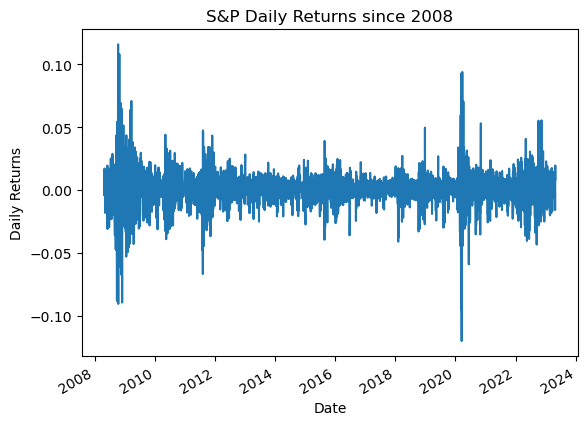

In [36]:
# S&P 500 hold 
df['daily_returns'] = df['Adj Close'].pct_change()
df['daily_returns'].plot()
plt.ylabel('Daily Returns')
plt.xlabel('Date')
plt.title('S&P Daily Returns since 2008')
plt.show()

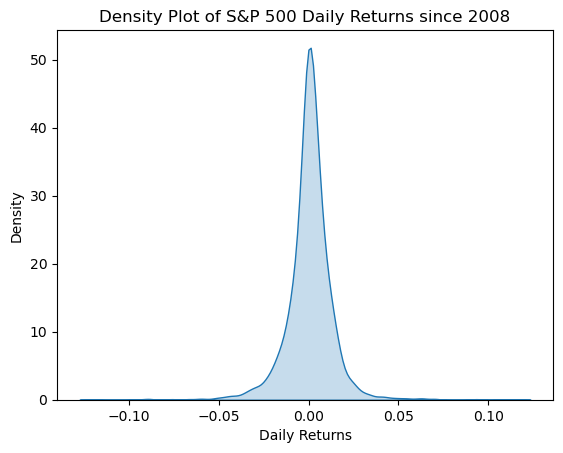

In [37]:
# S&P 500 hold
sns.kdeplot(df['daily_returns'], fill=True)
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Density Plot of S&P 500 Daily Returns since 2008')
plt.show()

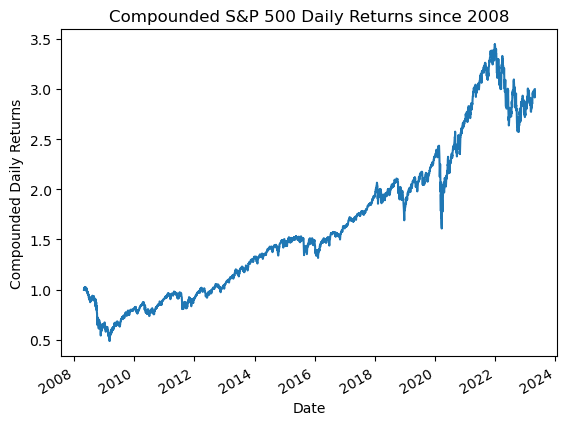

In [38]:
# S&P 500 hold
df['compounded_cum_return'] = (1 + df['daily_returns']).cumprod()
df['compounded_cum_return'].plot()
plt.ylabel('Compounded Daily Returns')
plt.xlabel('Date')
plt.title('Compounded S&P 500 Daily Returns since 2008')
plt.show()

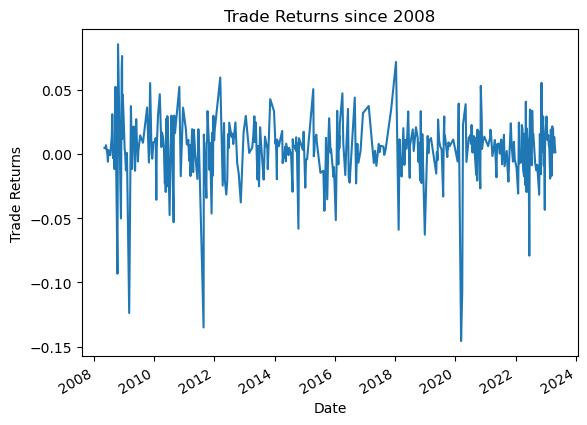

In [39]:
# trade strategy
df.loc[df['trade_returns'].notnull()]['trade_returns'].plot()
plt.ylabel('Trade Returns')
plt.xlabel('Date')
plt.title('Trade Returns since 2008')
plt.show()

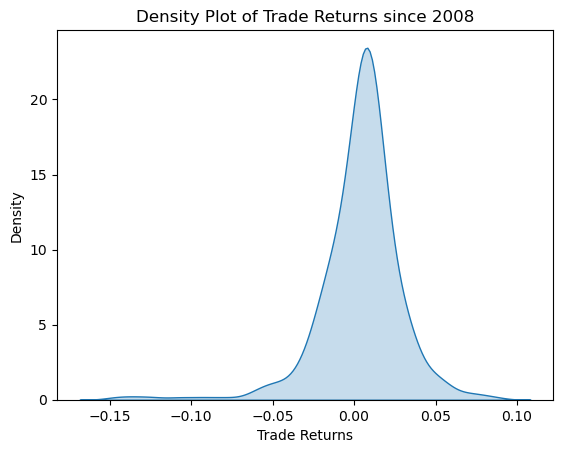

In [40]:
# trade strategy
sns.kdeplot(df['trade_returns'], fill=True)
plt.xlabel('Trade Returns')
plt.ylabel('Density')
plt.title('Density Plot of Trade Returns since 2008')
plt.show()

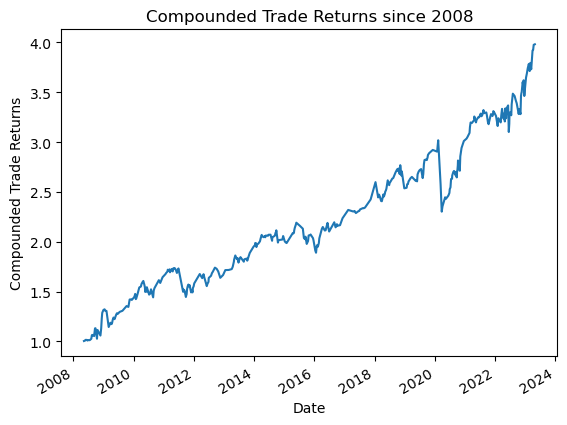

In [41]:
# trade strategy
df.loc[df['cumulative_returns'].notnull()]['cumulative_returns'].plot()
plt.ylabel('Compounded Trade Returns')
plt.xlabel('Date')
plt.title('Compounded Trade Returns since 2008')
plt.show()

In [42]:
df[['Adj Close', 'Pred', 'trade_returns', 'cumulative_returns', 'daily_returns', 'compounded_cum_return']].describe()

,Adj Close,Pred,trade_returns,cumulative_returns,daily_returns,compounded_cum_return
count,3653.000000,3653.000000,400.000000,400.000000,3652.000000,3652.000000
mean,2285.551623,0.076102,0.003786,2.253689,0.000388,1.643347
std,1053.337597,0.670298,0.025236,0.753552,0.013222,0.757314
min,676.530029,-1.000000,-0.145558,1.004846,-0.119841,0.486383
25%,1343.599976,0.000000,-0.006172,1.637064,-0.004290,0.965922
50%,2077.989990,0.000000,0.006424,2.095113,0.000692,1.494080
75%,2905.030029,1.000000,0.015107,2.771551,0.005991,2.088636
max,4793.060059,1.000000,0.085434,3.981541,0.115800,3.445914


In [43]:
# S&P 500 returns, volatility, and sharpe ratio
cumulative_returns = df['compounded_cum_return'].dropna().iat[-1]-1
years = len(df)/252
annualized_returns_sp = (cumulative_returns+1)**(1/years)-1

volatility_sp = df['daily_returns'].std()*np.sqrt(252)  

sharpe_ratio_sp = (annualized_returns_sp - 0.03)/volatility_sp

In [44]:
# trade strategy returns, volatility, and sharpe ratio
cumulative_returns = df['cumulative_returns'].dropna().iat[-1]-1
years = len(df)/252
annualized_returns_trd = (cumulative_returns+1)**(1/years)-1

num_trades = len(df.loc[df['trade_returns'].notnull()])
active_day_fraction = num_trades/len(df)
volatility_trd = df['trade_returns'].std()*np.sqrt(252*active_day_fraction)  

sharpe_ratio_trd = (annualized_returns_trd - 0.03)/volatility_trd

In [45]:
# Create two Pandas Series objects to store the data for each set
sp_data = pd.Series([annualized_returns_sp, volatility_sp, sharpe_ratio_sp], 
                      index=['Annualized Returns', 'Volatility', 'Sharpe Ratio'])
trd_data = pd.Series([annualized_returns_trd, volatility_trd, sharpe_ratio_trd], 
                      index=['Annualized Returns', 'Volatility', 'Sharpe Ratio'])

# Concatenate the two series into a single dataframe
comparison_table = pd.concat([sp_data, trd_data], axis=1)
comparison_table.columns = ['S&P 500 Hold', 'Trade Strategy']

# Print the table
display(comparison_table.T)

,Annualized Returns,Volatility,Sharpe Ratio
S&P 500 Hold,0.078673,0.209886,0.231903
Trade Strategy,0.100004,0.132565,0.528073
